In [ ]:
#
#
#
from qat.lang.AQASM import Program,AbstractGate,QRoutine,H,X,CNOT
import numpy as np


 Exemple de Cindy : L’algorithme de Deutsch–Jozsa sur 2 qbits puis sur 4 bits
 
 Contexte : on a deux boites avec soit une pomme soit une orange.
 
 Question : a-t-on le même fruit dans les deux boites ? Sans avoir à dire quel fruit mais sans ouvrir les deux boites.

 Formalisme mathématique :
Soit une fonction $f : \{0,1\}\rightarrow \{0,1\}$.<br>
La question est  de savoir si on a 

$f(0)=f(1)$ cas constant 

ou bien

$f(0)\neq f(1)$ cas équilibré

on definit l'Oracle $O_f$ par $$O_f|x,y>=|x,y\oplus f(x)>$$

Ensuite on programe l'ago de Deutsch donné par le circuit

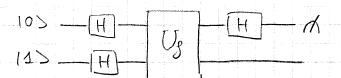

<br>
La mesure de l'état de sortie du 1er qbt donne la réponse : s'il vaut |0> $f$ est constante, s'il vaut |1> alors $f$ est équilibré
 

1ere methode avec des Abstract Gates 
inconvenient : il faut calculer la matrice

In [ ]:
Of = AbstractGate("Of", [], arity=2)
def Of_generator0():
    # Fonction constante égale à 0 il n'y a rien à faire
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

# We can now attach this generator to our gate
Of.set_matrix_generator(Of_generator0)
# Equivalently, we could have defined the gate directly as follows:
#Of = AbstractGate("Of", [float], arity=2, matrix_generator=Of_generator0)

Programmer les 3 autres oracles 

In [ ]:
#proposition  de solution

def Of_generator1():
    # Fonction constante égale à 1
    return np.array([[0, 1, 0, 0],
                     [1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]])
def Of_generatorId():
    # Fonction equilibree identite. : CNOT
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]])
def Of_generatorX():
    # Fonction equilibree  : CNOT controle par 1
    return np.array([[0, 1, 0, 0],
                     [1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])



In [ ]:
# utilisation dans le circuit :
prog = Program()
qbits = prog.qalloc(2)
prog.apply(H, qbits[0])
prog.apply(X, qbits[1])
prog.apply(H, qbits[1])
prog.apply(Of(), qbits)
prog.apply(H, qbits[0])

circuit = prog.to_circ(box_routines=True)
circuit.display()
from qat.qpus import PyLinalg
# measuring qubit #0 50 times
result = PyLinalg().submit(circuit.to_job(qubits=[0], nbshots=50))
for res in result:
    print("Qubit 0 has value %s (the probability of getting this result is %s +/- %s)"%(int(res.state[0]),
                                                                                 res.probability, res.err))
print()


Tester avec les 3 autres oracles possibles

In [ ]:
#Il vaut mieux programmer une qroutine qu'une abstractgate 
# ci dessous les 4 cas possibles
Or = QRoutine()
wires = Or.new_wires(2)
#1 rien fonction constante égale à 0
#2 fonction constante egale à 1
#  rout.apply(X,wires[1]) 
#3 fonction identité f(0)=0 f(1)=1
#rout.apply(CNOT,wires)  
#4 fonction f(0)=1 et f(1)=0. 
#. CNOT controlée par le 1er bit égal à 1
Or.apply(X,wires[0])
Or.apply(CNOT,wires)  
Or.apply(X,wires[0])
Or.display()
#help(display)

In [ ]:
prog = Program()
qbits = prog.qalloc(2)
prog.apply(H, qbits[0])
prog.apply(X, qbits[1])
prog.apply(H, qbits[1])
prog.apply(Or, qbits)
prog.apply(H, qbits[0])

circuit = prog.to_circ(box_routines=True)
circuit.display()
from qat.qpus import PyLinalg
# measuring qubit #0 50 times
result = PyLinalg().submit(circuit.to_job(qubits=[0], nbshots=50))
for res in result:
    print("Qubit 0 has value %s (the probability of getting this result is %s +/- %s)"%(int(res.state[0]),
                                                                                 res.probability, res.err))
print()


In [ ]:
# rien n'empeche d'encapsuler ensuite la qroutine dans une abstractGate 
#pour la faire apparaitre dans le circuit
Or = QRoutine()
wires = Or.new_wires(2)
def my_unknown_f0():
    # f(0)=0 et f(1)=0 
    return Or
def my_unknown_f1():
    # f(0)=1 et f(1)=1 
    Or.apply(X,wires[1]) 
    return Or
def my_unknown_f2():
    # f(0)=0 et f(1)=1 
    Or.apply(CNOT,wires)  
    return Or
def my_unknown_f3():
    # f(0)=1 et f(1)=0 
    Or.apply(X,wires[0])
    Or.apply(CNOT,wires)  
    Or.apply(X,wires[0])
    return Or

In [ ]:
# We can now add this circuit generator to the GateSignature object
Orq = AbstractGate("Or", [])
Orq.set_circuit_generator(my_unknown_f3)
# Of course, one could have written:
#Orq = AbstractGate("Or", [], circuit_generator=my_unknown_f3)


prog = Program()
qbits = prog.qalloc(2)
prog.apply(H, qbits[0])
prog.apply(X, qbits[1])
prog.apply(H, qbits[1])
prog.apply(Orq(), qbits)
prog.apply(H, qbits[0])

circuit = prog.to_circ(box_routines=True)
circuit.display()
from qat.qpus import PyLinalg
# measuring qubit #0 50 times
result = PyLinalg().submit(circuit.to_job(qubits=[0], nbshots=50))
for res in result:
    print("Qubit 0 has value %s (the probability of getting this result is %s +/- %s)"%(int(res.state[0]),
                                                                                 res.probability, res.err))
print()

Généralisation à n-qbits : Algorithme de Deutsch–Jozsa

Terminologie. Soit une fonction $f : (Z/2Z)^{2n}\rightarrow Z/2Z$
que l’on peut aussi voir comme une fonction
$f : \{0, 1\}^n \rightarrow\{0, 1\}$. Il y a $2^{(2n)}$ fonctions différentes possibles mais nous n’allons considérer que deux types
de fonctions.<br>
 $f$ est constante si pour tout $(x_1,\ldots, x_n)$ on a $f(x_1,\ldots, x_n) = 0$ ou bien si pour tout $(x_1,\ldots, x_n)$ on a $f(x_1,\ldots, x_n) = 1$. Il existe donc deux fonctions constantes.
<br>
f est équilibrée s’il y a autant de n-uplets $(x_1,\ldots, x_n)$ tels que $f(x_1,\ldots, x_n) = 0$ que de n-uplets
de n-uplets $(x_1,\ldots, x_n)$ tels que $f(x_1,\ldots, x_n) = 1$ 
autrement dit

$$Card\left\{(x_1,\ldots, x_n)\in(Z/2Z)^{2n}|f(x_1,\ldots, x_n) = 0\right\}=Card\left\{(x_1,\ldots, x_n)\in(Z/2Z)^{2n}|f(x_1,\ldots, x_n) = 1\right\}$$

Il y a $\left(\dfrac{2^n}{2^{n-1}}\right)$ telles fonctions. Dès que $n>1$ 
il y a beaucoup plus de fonctions qui ne sont ni constantes ni équilibrées.
<br>
Le problème à résoudre est : sachant qu'une fonction $f$ est soit constante, soit équilibrée, déterminer duquel des deux types elle est.


Circuit quantique

In [ ]:
#definition de l'oracle
n=4


#la première fonction constante
# f(j)=0 pour tout j - rien à faire
Orn = QRoutine()
wires = Orn.new_wires(n+1)




In [ ]:
prog = Program()
qbits = prog.qalloc(n+1)
for i in range(n):
    prog.apply(H, qbits[i])
prog.apply(X, qbits[n])
prog.apply(H, qbits[n])
prog.apply(Orn, qbits)
for i in range(n):
    prog.apply(H, qbits[i])
circuit = prog.to_circ(box_routines=True)
circuit.display()
from qat.qpus import PyLinalg
circuit = prog.to_circ(submatrices_only=False)
result = PyLinalg().submit(circuit.to_job())
for sample in result:
    print("State %s, amplitude %s, probability %s"%(sample.state, sample.amplitude, sample.probability))

print("Si la mesure des n premiers qbits est 0....0000 alors f est constante",
     "Sinon f est equilibree")
result.plot()


Programmer l'oracle correspondant à l'autre cas constant, et un oracle correspondant à un cas équilibré. Puis tester

In [ ]:
#proposition de solution
Orn = QRoutine()
wires = Orn.new_wires(n+1)
# un cas équilibré
# f(j)=1 si le premier bit est 1, 0 sinon - CNOT controlé par le 1er bit
Orn.apply(X,wires[0])
Orn.apply(CNOT,wires[0],wires[n]) 
Orn.apply(X,wires[0])

# la deuxième fonction constante
# f(j)=1 pour tout j - appliquer X à y
Orn = QRoutine()
wires = Orn.new_wires(n+1)
Orn.apply(X,wires[n]) 

